In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cargar el dataset limpio
df = pd.read_csv('clean_salary_data.csv')

In [5]:
# 1. PREPARACIÓN DE DATOS
print("Dimensiones del dataset:", df.shape)

# Eliminar columnas que no serán útiles para el modelo
columns_to_drop = [
    # Eliminar identificadores y datos redundantes
    'job_title',  # Usaremos job_category que es más general
    'tech_stack',  # Texto descriptivo, difícil de utilizar directamente
    
    # Métricas derivadas que pueden causar data leakage
    'salary_bracket',  # Derivada directamente del target
    'salary_competitiveness',  # Basada en el target
    'normalized_salary',  # Derivada del target
    'adjusted_salary',  # Derivada del target
    'total_compensation_estimate',  # Derivada del target
]

# Crear dataset para modelado
model_df = df.drop(columns=columns_to_drop)

# Separar variable objetivo (target) y predictores
X = model_df.drop(columns=['salary_in_usd', 'salary_to_experience_ratio'])
y = model_df['salary_in_usd']

print("Variables predictoras:", X.shape[1])
print("Variables seleccionadas:", X.columns.tolist())

# Identificar tipos de columnas
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Variables categóricas: {len(categorical_cols)}")
print(f"Variables numéricas: {len(numerical_cols)}")

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Dimensiones del dataset: (3755, 31)
Variables predictoras: 22
Variables seleccionadas: ['work_year', 'employee_residence', 'company_location', 'job_category', 'experience_level_desc', 'employment_type_desc', 'work_setting', 'company_size_desc', 'region', 'residence_region', 'domestic_employment', 'cost_of_living_index', 'english_level', 'tech_specialization', 'role_maturity', 'career_path', 'ai_relationship', 'demand_index', 'economic_period', 'work_life_balance', 'automation_risk', 'company_sector']
Variables categóricas: 16
Variables numéricas: 6


In [6]:
# 2. PREPROCESAMIENTO Y PIPELINE

# Preprocesador para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Preprocesador para variables numéricas
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Unir los preprocesadores en un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

In [7]:
# 3. MODELOS A EVALUAR

# Definir varios modelos para comparar
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [8]:
# 4. EVALUACIÓN DE MODELOS
results = {}
best_model = None
best_score = -float('inf')
best_model_name = ''

print("\nEvaluando modelos con validación cruzada...")

for name, model in models.items():
    # Crear pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Entrenar y evaluar con validación cruzada
    cv_scores = cross_val_score(
        pipeline, X_train, y_train, 
        cv=5, 
        scoring='neg_root_mean_squared_error'
    )
    
    # Almacenar resultados
    mean_cv_score = -cv_scores.mean()  # Convertir a valor positivo para RMSE
    results[name] = {
        'cv_rmse': mean_cv_score,
        'cv_scores': -cv_scores  # Todos positivos para RMSE
    }
    
    print(f"{name}: CV RMSE = ${mean_cv_score:.2f}")
    
    # Actualizar mejor modelo
    if -mean_cv_score > best_score:
        best_score = -mean_cv_score
        best_model_name = name
        best_model = model

print(f"\nMejor modelo basado en CV: {best_model_name}")


Evaluando modelos con validación cruzada...
Linear Regression: CV RMSE = $49628.92
Ridge Regression: CV RMSE = $48953.98
Lasso Regression: CV RMSE = $49504.11
Random Forest: CV RMSE = $49725.71
Gradient Boosting: CV RMSE = $48460.66

Mejor modelo basado en CV: Gradient Boosting


In [9]:
# 5. AJUSTE DE HIPERPARÁMETROS DEL MEJOR MODELO

# Configurar grid de hiperparámetros según el mejor modelo
if best_model_name == 'Random Forest':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__max_depth': [3, 5, 7]
    }
else:  # Para modelos lineales
    param_grid = {
        'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
    }

print(f"\nAjustando hiperparámetros para {best_model_name}...")

# Crear pipeline con el mejor modelo
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_model)
])

# Realizar búsqueda de grid
grid_search = GridSearchCV(
    best_pipeline,
    param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor RMSE en CV: ${-grid_search.best_score_:.2f}")


Ajustando hiperparámetros para Gradient Boosting...
Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}
Mejor RMSE en CV: $48460.66


In [10]:
# 6. EVALUACIÓN DEL MODELO FINAL EN CONJUNTO DE PRUEBA
optimized_model = grid_search.best_estimator_

# Predecir en conjunto de prueba
y_pred = optimized_model.predict(X_test)

# Calcular métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nRendimiento en conjunto de prueba:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE: ${mae:.2f}")
print(f"R² Score: {r2:.4f}")


Rendimiento en conjunto de prueba:
RMSE: $48450.43
MAE: $37201.02
R² Score: 0.4054


In [11]:
# 7. ANÁLISIS DE IMPORTANCIA DE CARACTERÍSTICAS

# Obtener nombres de características después del preprocesamiento
preprocessor_fitted = optimized_model.named_steps['preprocessor']
model_fitted = optimized_model.named_steps['model']

# Obtener nombres de columnas transformadas
cat_features = preprocessor_fitted.transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_features)

# Definir función para obtener importancia de características según el modelo
def get_feature_importance(model_name, model, X, y, feature_names, preprocessor):
    X_transformed = preprocessor.transform(X)
    
    if model_name in ['Random Forest', 'Gradient Boosting']:
        # Para modelos basados en árboles, usar importancia incorporada
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            return [(feature_names[i], importances[i]) for i in indices]
    
    # Para cualquier modelo, usar importancia de permutación
    result = permutation_importance(model, X_transformed, y, n_repeats=10, random_state=42)
    importances = result.importances_mean
    indices = np.argsort(importances)[::-1]
    return [(feature_names[i], importances[i]) for i in indices]

# Obtener importancia de características
feature_importance = get_feature_importance(
    best_model_name, 
    model_fitted, 
    X_test, 
    y_test, 
    feature_names, 
    preprocessor_fitted
)

# Mostrar las 20 características más importantes
print("\nCaracterísticas más importantes:")
for i, (feature, importance) in enumerate(feature_importance[:20]):
    print(f"{i+1}. {feature}: {importance:.4f}")


Características más importantes:
1. residence_region_North America: 0.3800
2. employee_residence_US: 0.0968
3. demand_index: 0.0806
4. experience_level_desc_Executive: 0.0693
5. experience_level_desc_Senior: 0.0579
6. experience_level_desc_Entry-Level: 0.0418
7. automation_risk: 0.0329
8. company_sector_Technology: 0.0304
9. tech_specialization: 0.0266
10. english_level_Intermediate: 0.0240
11. company_location_US: 0.0202
12. employee_residence_IL: 0.0133
13. cost_of_living_index: 0.0131
14. work_year: 0.0122
15. company_size_desc_Large: 0.0102
16. experience_level_desc_Mid-Level: 0.0101
17. ai_relationship_Develops AI: 0.0065
18. company_location_IL: 0.0059
19. employment_type_desc_Contract: 0.0058
20. work_life_balance: 0.0058


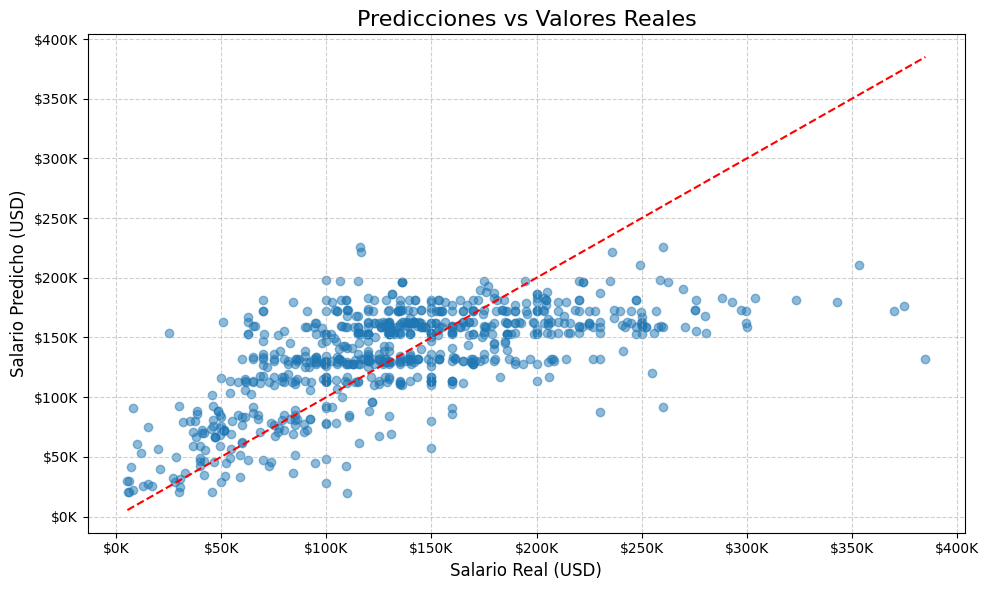

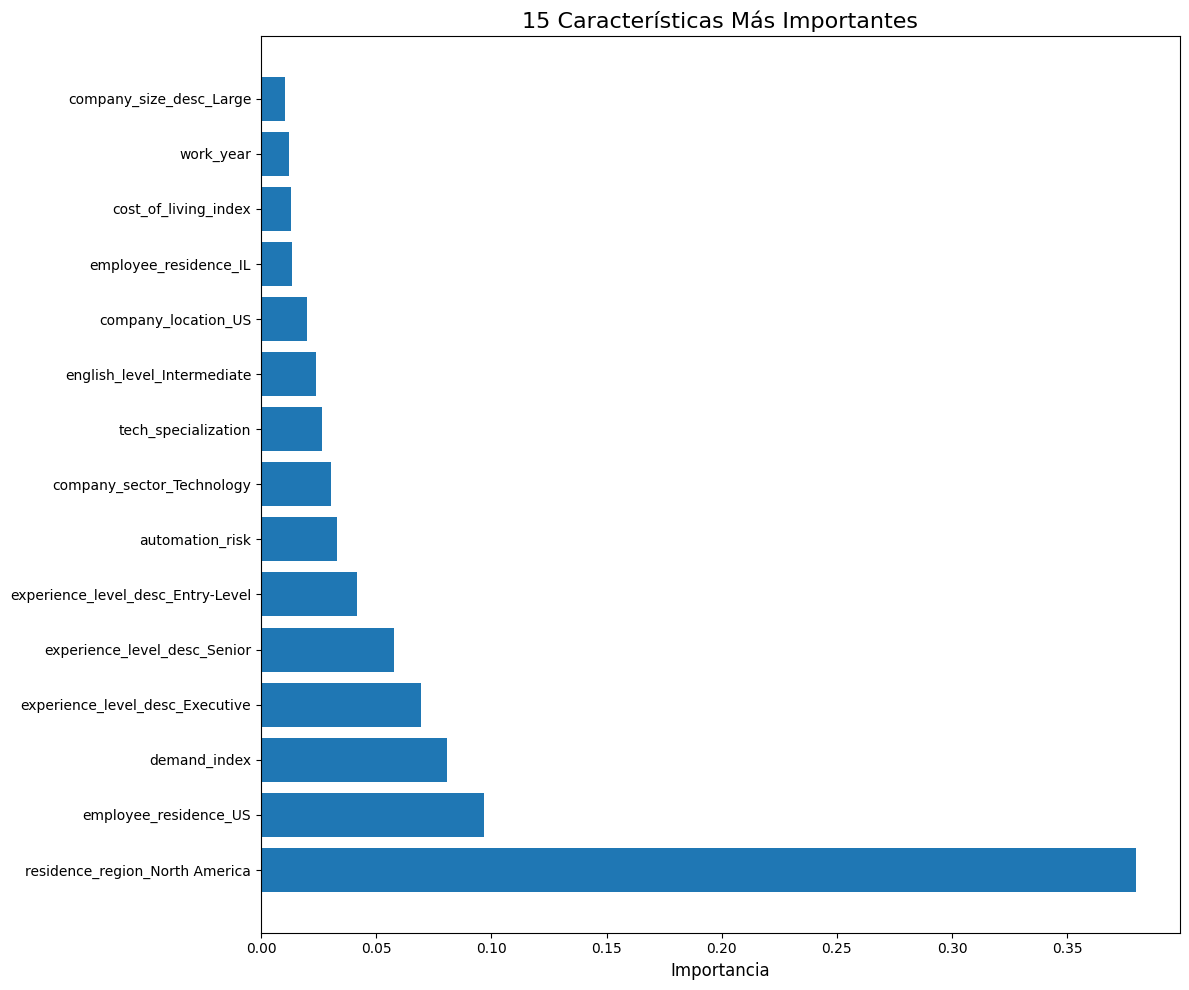

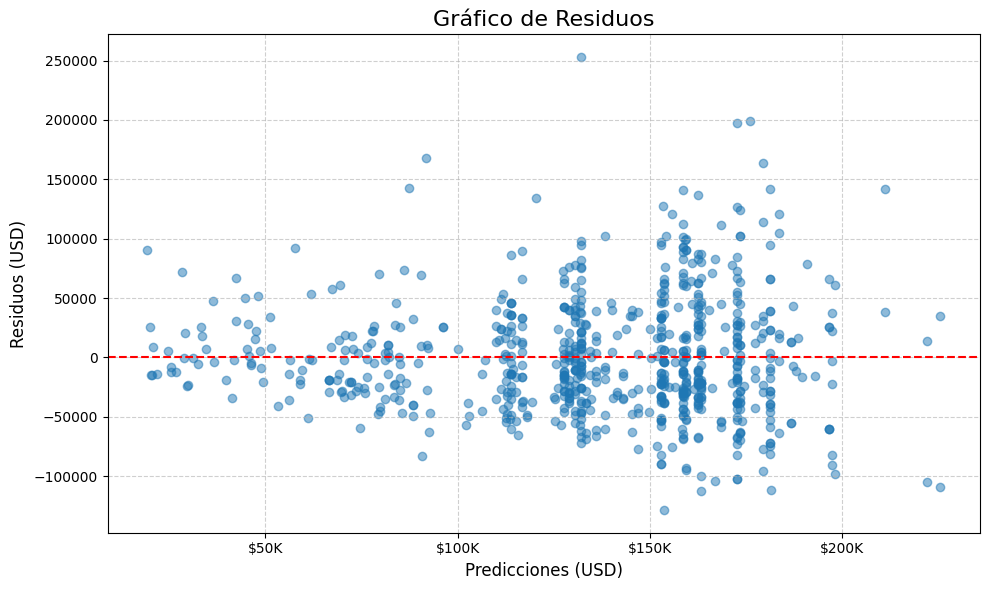

In [12]:
# 8. VISUALIZACIÓN DE RESULTADOS

# Gráfico de predicciones vs valores reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Salario Real (USD)', fontsize=12)
plt.ylabel('Salario Predicho (USD)', fontsize=12)
plt.title('Predicciones vs Valores Reales', fontsize=16)

# Formatear ejes para mostrar valores en miles
def format_salary(x, pos):
    return f'${x/1000:.0f}K'
    
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_actual.png", dpi=300)
plt.show()

# Gráfico de importancia de características
plt.figure(figsize=(12, 10))
top_features = feature_importance[:15]
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

plt.barh(range(len(top_features)), importances, align='center')
plt.yticks(range(len(top_features)), [f[:40] + '...' if len(f) > 40 else f for f in features])
plt.xlabel('Importancia', fontsize=12)
plt.title('15 Características Más Importantes', fontsize=16)
plt.tight_layout()
plt.savefig("feature_importance.png", dpi=300)
plt.show()

# Gráfico de residuos
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicciones (USD)', fontsize=12)
plt.ylabel('Residuos (USD)', fontsize=12)
plt.title('Gráfico de Residuos', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_salary))
plt.tight_layout()
plt.savefig("residuals.png", dpi=300)
plt.show()